<a href="https://colab.research.google.com/github/cwhung/credit_card_fraud_unsupervised_machine_learning/blob/master/Final_Capstone_Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit Card Fraud Detection Using Machine Learning**

Credit card fraud has been a serious problem to causes huge loss to financial companies and retailers as well.  In order to catch the fraudulent activities, a classifier model to predict the fraud case is in special need. In this project, predictive models are built for credit card fraud activity detection using supervised and unsupervised machine learning techniques.  The models would help detect future suspicious activities when it occurs and block any further fraudulent transactions.  

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import warnings
# warnings.filterwarnings('ignore')

import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import IPython.display as display
from PIL import Image

# specifying 2.0
%tensorflow_version 2.x

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

## Load the data from Kaggle

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [0]:
from google.colab import files
files.upload()# upload your kaggle.json file

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 

Saving kaggle.json to kaggle.json
     |████████████████████████████████| 122kB 5.1MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.7.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.21.0, but you'll have requests 2.22.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.13.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
kaggle.json


In [0]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

 79% 52.0M/66.0M [00:00<00:00, 32.5MB/s]
100% 66.0M/66.0M [00:01<00:00, 68.0MB/s]


In [0]:
for dirname, _, filenames in os.walk('/kaggle'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [0]:
!unzip \*.zip

Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [0]:
df= pd.read_csv('creditcard.csv')

# First Peek

In [0]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [0]:

df.shape

(284807, 31)

The dataset has V1-V28, Time, and amount (30 features total) and one target column (**Class**).  There are 284807 rows.  

In [0]:

df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [0]:
df.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

The average transaction is $88.35. Only 0.17% (492) of (287407) transctions are fraud (highly unbalanced).


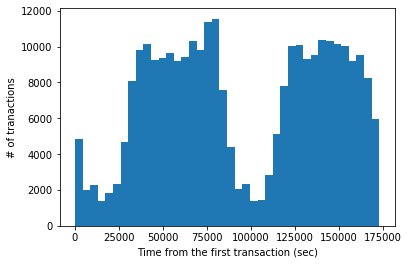

In [0]:
plt.hist(df.Time, bins=40)
plt.xlabel('Time from the first transaction (sec)')
plt.ylabel('# of tranactions')
plt.show()

# Feature engineering

Time column records the transaction time in seconds.  Time would be transformed to "time in a day".  Doing so we achieve two things: 1. Converting time from interval data to ratio data so that it would represent the same time in every day. 2. Data Normalization between 0 to 1. 

Creating new features

In [0]:
# since 'Time' is recorded as seconds from the first transaction, ...
# we can make time relevant by substract 86400 from time.... then divided by 86400
# T is the fraction of the time in a day (normalized)


df['T']= [n/86400 if n<86400 else (n-86400)/86400 for n in df['Time']]



import math

# Create logarithm of Amount
# because the original amount is very screwed.  

df['log_amount']=[0 if n<=1 else math.log10(n) for n in df['Amount']]

# Further normalized amount so that the whole dataset is standardized

from sklearn.preprocessing import StandardScaler

df['nor_amount']= StandardScaler().fit_transform(df['log_amount'].values.reshape(-1,1))


df=df.drop(columns=['Time', 'Amount', 'log_amount'])
column_list=df.drop(columns=['Class']).columns.tolist() + ['Class']

df.head()



,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,T,nor_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.000000,1.097442
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.000000,-1.111041
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0.000012,1.607740
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.000012,0.992002
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.000023,0.679907


## Split the dataset for testing purpose

In [0]:
# Separate target variable from other metrics
x= df.drop('Class', axis=1)
y= df['Class']

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print('Class in training dataset: {}'.format(y_train.value_counts()))
print('Class in testing dataset: {}'.format(y_test.value_counts()))

Class in training dataset: 0    227451
1       394
Name: Class, dtype: int64
Class in testing dataset: 0    56864
1       98
Name: Class, dtype: int64


#Create balanced datasets from training dataset¶
Since more than 99% of the data are fraudulent free, we would like to have a dataset that is more balanced to predict fraud. Otherwise, the accuracy of 99% does not mean the frauds are labeled. Oversampling (on minority group) dataset is created for supervised machine learning and neutral networks.  Undersampling dataset is applied to unsupervised learning models when sample size is critical to the preformance to these unsuperised learning models.   

## Oversampling Dataset for supervised machine learning models

In [0]:

## oversampling 
from imblearn.over_sampling import SMOTE
# Create new dataset X_res, Y_res (res stand for resampling)
smt=SMOTE(random_state=42)
x_res, y_res= smt.fit_resample(X_train, y_train)
# reassign the column names
X_res= pd.DataFrame(data=x_res, columns=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'T', 'nor_amount'])
Y_res=pd.DataFrame(data=y_res, columns=['Class'])

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Undersampling dataset for unsupervised machine learning models

In [0]:
# undersampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
x_res2, y_res2 = rus.fit_resample(x, y)
# reassign the column names
X_res2= pd.DataFrame(data=x_res2, columns=['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'T', 'nor_amount'])
Y_res2=pd.DataFrame(data=y_res2, columns=['Class'])

In [0]:
# Class numbers in oversampling dataset
Y_res.Class.value_counts()

1    227451
0    227451
Name: Class, dtype: int64

In [0]:
# Class numbers in undersampling dataset
Y_res2.Class.value_counts()

1    492
0    492
Name: Class, dtype: int64

This would create two datasets where there are same number of frauds as the non-frauds. By undersampling the majority group or oversamlping the minority group, the new datasets contain equal number of Class 0 and Class 1. 

## Exploratory data analysis

Correlation Map on the original dataset

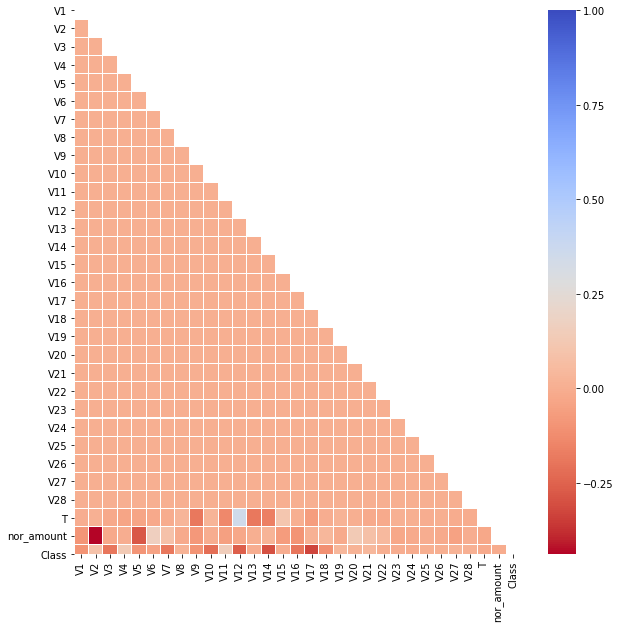

In [0]:
# Compute the correlation matrix
corr = df[column_list].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, mask=mask, cmap='coolwarm_r', annot=False, linewidths=.1, fmt= '.1f',ax=ax)
plt.show()

Correlation Map on the Oversampling dataset

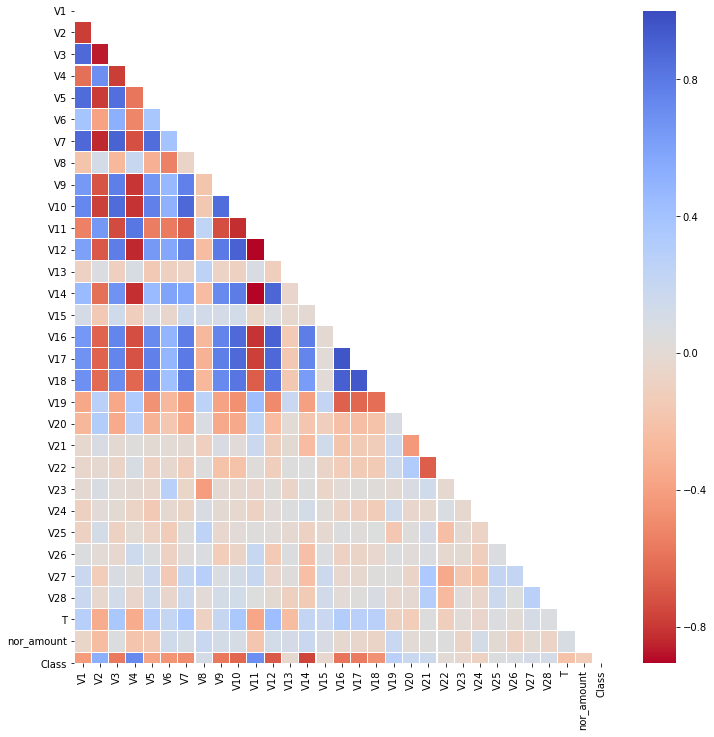

In [0]:
train=pd.concat([X_res, Y_res], axis=1)

# Compute the correlation matrix
corr = train[column_list].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr, mask=mask, cmap='coolwarm_r', annot=False, linewidths=.1, fmt= '.1f',ax=ax)
plt.show()

From the correlation map, V1, V3, V5, V6, V7, V9, V10, V12, V14, V16, V17 and V18 are inversely correlated to Class while V2, V4 and V11 are highly correlated in the Resampled dataset.

In [0]:
train.shape

(454902, 31)

Creating Boxplot on the metrics of interest by Class

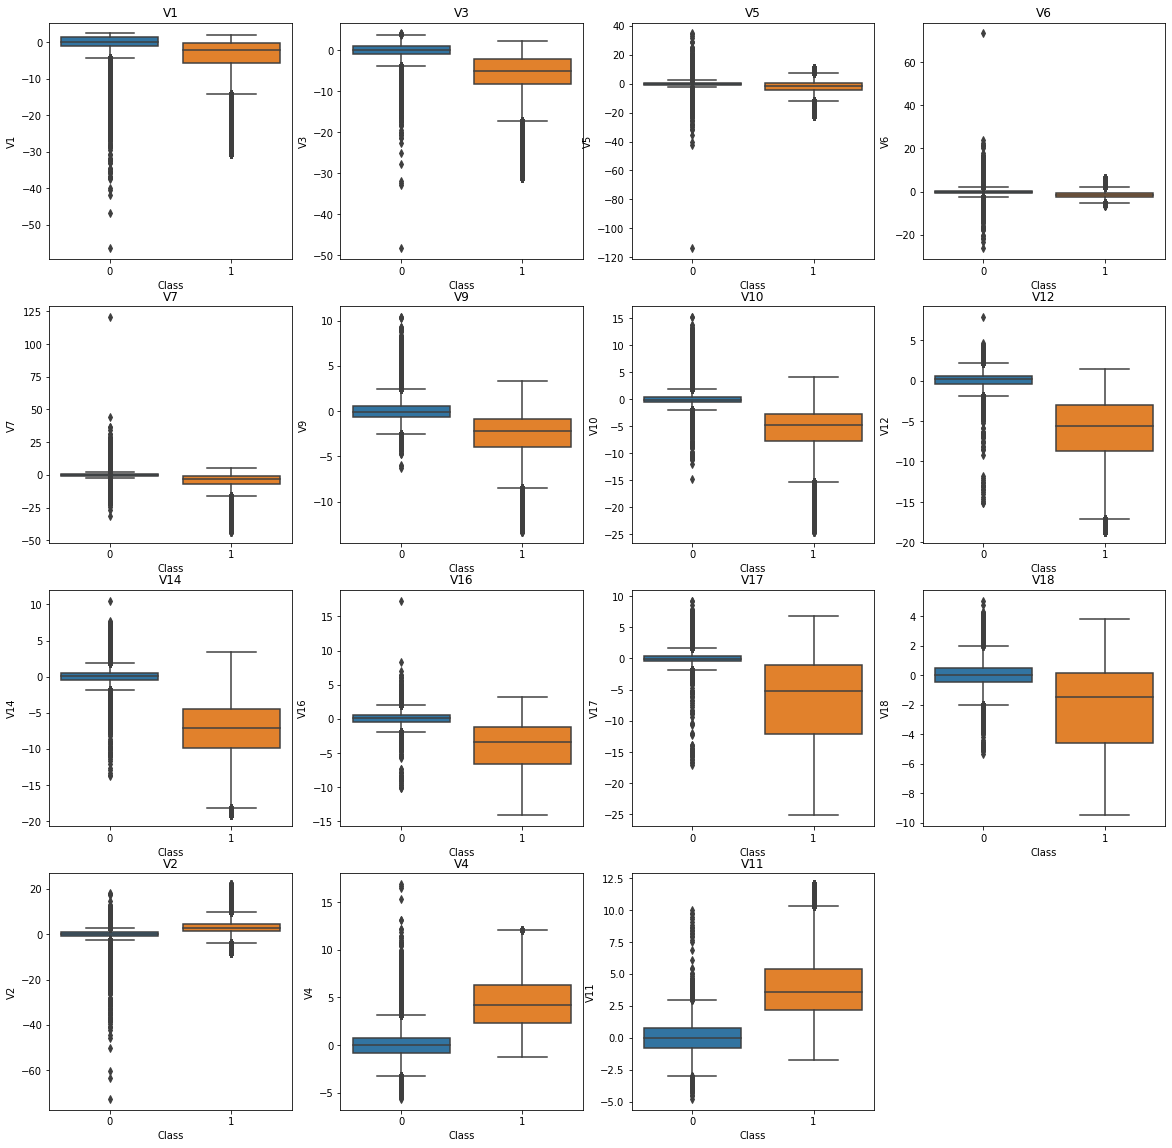

In [0]:
columns_of_interest=['V1', 'V3', 'V5', 'V6', 'V7', 'V9', 'V10', 'V12', 'V14', 'V16', 'V17', 'V18', 'V2','V4','V11']

plt.figure(figsize=(20,20))

for i, column in enumerate(columns_of_interest, start = 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x="Class", y=column, data=train)
    plt.title(column)    

plt.show()

The boxplots agrees with the correlation map.  The box on Class= 1 is lower than the box on Class=0 when the correlation map shows negatively correlated on V1, V3, V5, etc.  The box on Class=1 is higher than the box on Class=0 when the correlation map shows positively correlated on V2, V4, and V11. 

# Supervised Machine Learning
The models include Logistic Regression Classifier, Ridge Classifier, AdaBoost Classifier, Decision Tree Classifier, Extra Tree Classifier, Random Forest Classifier, Gradient Boosting Classifier, K-Neighbor Classifier, MLP Classifier, Gaussian Classifier, Quadratic Discriminant Analysis, Bagging (with Decision Tree), Stacking (1. with Ridge, Random Forest, and AdaBoost, 2. with adaBoost, Decision Tree and K-Neighbor), adaboosting on Random Forest, xgboost, and lgbm classifier.  

In [0]:
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from mlxtend.classifier import StackingClassifier
import xgboost as xgb
import lightgbm as lg


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, recall_score

In [0]:
cl0 = LogisticRegression(solver='lbfgs', random_state = 42)
cl1 = RidgeClassifier(random_state = 42)
cl2 = RandomForestClassifier(n_estimators=20, random_state = 42)
cl3 = AdaBoostClassifier(random_state = 42)
cl4 = DecisionTreeClassifier(random_state = 42)
cl5 = KNeighborsClassifier()
cl6 = MLPClassifier(random_state = 42)
cl9 = GaussianNB()
cl10 = QuadraticDiscriminantAnalysis()
cl22 = ExtraTreesClassifier()# randomized decision trees

# Bagging
cl11 = BaggingClassifier(base_estimator=cl4, random_state = 42)

# Stacking
cl13 = StackingClassifier(classifiers=[cl1, cl2, cl3], meta_classifier=cl0)
cl14 = StackingClassifier(classifiers=[cl3, cl4, cl5], meta_classifier=cl2)

# Boost
cl15 = AdaBoostClassifier(base_estimator=cl2, n_estimators=3)   
cl16 = AdaBoostClassifier(base_estimator=cl2, n_estimators=10)
cl17 = AdaBoostClassifier(base_estimator=cl2, n_estimators=15)   
cl18 = AdaBoostClassifier(base_estimator=cl2, n_estimators=20)
cl19 = GradientBoostingClassifier(n_estimators=20, random_state = 42)

# XGBoost. try early stopping
cl20 = xgb.XGBClassifier(n_estimators=400, random_state = 42)


# LightGBM. try early stopping
cl21 = lg.LGBMClassifier(n_estimators=400, random_state = 42)

names = ['Log','Ridge', 'RF', 'Ada', 'DT', 'KNN', 'MLP Neural Net', 'Bernoulli', 'Quadratic', 'Bagging', 
         'Stacking1', 'Stacking2', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)', 'AdaBoost (n_est=15)', 'AdaBoost (n_est=20)', 'GB Boost','XGboost', 
         'LightGBM', 'ExtraTrees']
cl = [cl0, cl1, cl2, cl3, cl4, cl5, cl6, cl9, cl10, cl11, cl13, cl14, cl15, cl16, cl17, cl18, cl19, cl20, cl21, cl22]


for i, k in zip(names, cl) :
  k.fit(X_res.values, Y_res.values.ravel())# replace your code here
  pred = k.predict(X_test.values)# replace your code
  print (("f1 score for {} : {} ").format(i, round(f1_score(y_test.values, pred), 3 ) ))
  #print (("accuracy score for {} : {} ").format(i, round(accuracy_score(y_test.values, pred), 3 ) ))
  #print (classification_report(y_test.values, pred) )
  cm = confusion_matrix(y_test.values, pred.round())
  cm = pd.DataFrame(cm, columns=['No Fraud (Predicted)', 'Fraud (Predicted)'], index = ['No Fraud (Actual)', 'Fraud (Actual)'])
  print ('confusion matrix for ' + i)
  print ('\n')
  print (cm)
  print ('\n')
  print ('=======================')


  #prob = clf.predict_proba(df)
  #print (classification_report(Y, pred ) )


f1 score for Log : 0.108 
confusion matrix for Log


                   No Fraud (Predicted)  Fraud (Predicted)
No Fraud (Actual)                 55385               1479
Fraud (Actual)                        8                 90


f1 score for Ridge : 0.199 
confusion matrix for Ridge


                   No Fraud (Predicted)  Fraud (Predicted)
No Fraud (Actual)                 56211                653
Fraud (Actual)                       15                 83


f1 score for RF : 0.889 
confusion matrix for RF


                   No Fraud (Predicted)  Fraud (Predicted)
No Fraud (Actual)                 56857                  7
Fraud (Actual)                       14                 84


f1 score for Ada : 0.127 
confusion matrix for Ada


                   No Fraud (Predicted)  Fraud (Predicted)
No Fraud (Actual)                 55630               1234
Fraud (Actual)                        8                 90


f1 score for DT : 0.533 
confusion matrix for DT


                   

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


f1 score for ExtraTrees : 0.86 
confusion matrix for ExtraTrees


                   No Fraud (Predicted)  Fraud (Predicted)
No Fraud (Actual)                 56856                  8
Fraud (Actual)                       18                 80




The test dataset, splited from the original data, is a unbalanced dataset.  There are 98 fraudulent cases and 56864 no-fraud cases in the test dataset.  

#### Which performance metric? 
Accuracy is not a good performance metric because accuracy can be more than 0.99 in any models.  Two of the possible performance metrics are recall and f1-score.  When fraud detection is the only focus, recall would be the metric to report.  However, this could create another problem on false-positive cases when lots of non-fraudulent transactions need be investigated.  In this project, F1-score is selected as the indicator for the model performance because f1-score represents the combination of precision and recall.

Here are the top candidates: Random forest, stacking, adaboosting and lightGBM have f1-score > 0.8.  Logistic regression has an impressive recall (0.92).



# Credit Card Fraud Detection by Artificial Neutral Network (Tensorflow and Keras)

In [0]:
# The model expects 31 input_dim (X_train.shape[1]) With 4 layers and 1 dropout
# First hidder layer has 24 nodes with retified linear unit activation function
# Second hidder layer has 20 nodes
# Dropout with p =0.5
# Thrid hidder layer 10 nodes
# Fourth hidder layer 8 nodes
# last output layer uses sigmoid function


model = Sequential([
    Dense(units=24, input_dim = X_res.shape[1], activation='relu'),
    Dense(units=20,activation='relu'),
    Dropout(0.5),
    Dense(units=10,activation='relu'),
    Dense(units=8,activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 24)                744       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                500       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 88        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 1,551
Trainable params: 1,551
Non-trainable params: 0
______________________________________________________

In [0]:
# Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train model
model.fit(X_res, Y_res, validation_data=(X_test, y_test), batch_size=30, epochs=5)


Train on 454902 samples, validate on 56962 samples
Epoch 1/5
454902/454902 [==============================] - 30s 66us/sample - loss: 0.0368 - accuracy: 0.9869 - val_loss: 0.0154 - val_accuracy: 0.9973
Epoch 2/5
454902/454902 [==============================] - 29s 63us/sample - loss: 0.0110 - accuracy: 0.9972 - val_loss: 0.0148 - val_accuracy: 0.9976
Epoch 3/5
454902/454902 [==============================] - 29s 63us/sample - loss: 0.0084 - accuracy: 0.9979 - val_loss: 0.0112 - val_accuracy: 0.9987
Epoch 4/5
454902/454902 [==============================] - 28s 63us/sample - loss: 0.0070 - accuracy: 0.9983 - val_loss: 0.0126 - val_accuracy: 0.9982
Epoch 5/5
454902/454902 [==============================] - 29s 63us/sample - loss: 0.0065 - accuracy: 0.9985 - val_loss: 0.0122 - val_accuracy: 0.9984


In [0]:
# make prediction
y_pred = model.predict(X_test, verbose =1)

56962/56962 [==============================] - 1s 25us/sample


In [0]:
print (("f1 score for ANN : {} ").format(round(f1_score(y_test.values, y_pred.round()), 3 ) ))
cm = confusion_matrix(y_test, y_pred.round())
cm = pd.DataFrame(cm, columns=['No Fraud (Predicted)', 'Fraud (Predicted)'], index = ['No Fraud (Actual)', 'Fraud (Actual)'])
print(cm)

f1 score for ANN : 0.652 
                   No Fraud (Predicted)  Fraud (Predicted)
No Fraud (Actual)                 56784                 80
Fraud (Actual)                       12                 86


Tensorflow has f1-score 0.58 and recall 0.88. 

# Unsupervised Machine Learning: Clustering


K-Means


We applied 2-components PCA and use the 2-components for plotting. The data were divided into 4 equal datasets (X1, X2, X3, X4). After K-Means clustering, the plots shows the clusters in each parts. The idea is to observe the similarities of clustering in each datsets


In [0]:
from sklearn.cluster import KMeans
# Data frame to store features and predicted cluster memberships.
y_pred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_res2)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_res2,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.

from sklearn import metrics
from sklearn.metrics import pairwise_distances

scores=[]
column_names=[]

for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    y_pred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    y_pred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 10.
    for nclust in range(2, 11):
        model = KMeans(n_clusters=nclust, random_state=42).fit(data[0])
        pred = model.predict(data[0])
        y_pred['clust' + str(nclust) + '_sample' + str(counter)] = pred
        labels = model.labels_
        number_cluster = str(nclust)+'_cluster' 
        column_names.append(number_cluster)
        sil_score=metrics.silhouette_score(data[0], labels, metric='euclidean')
        scores.append(sil_score)

Silhouette Score is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).  We are looking for the clustering methods with the smallest std in Silhouette scores. 

In [0]:
silhouette_scores=pd.DataFrame(np.reshape(scores, (-1, 9)), columns=column_names[0:9])
silhouette_scores.index.name='Sample'

In [0]:

silhouette_scores

,2_cluster,3_cluster,4_cluster,5_cluster,6_cluster,7_cluster,8_cluster,9_cluster,10_cluster
Sample,,,,,,,,,
0,0.593806,0.462484,0.464102,0.392380,0.401189,0.378264,0.372653,0.313117,0.180051
1,0.661705,0.648774,0.469583,0.473045,0.483369,0.426367,0.437674,0.415378,0.388271
2,0.630700,0.463854,0.474308,0.488196,0.494992,0.475943,0.442992,0.447807,0.458146
3,0.617729,0.449051,0.449201,0.445313,0.391453,0.394092,0.398562,0.388020,0.391696


In [0]:

silhouette_scores.describe().T.sort_values(['std'], ascending=True)

,count,mean,std,min,25%,50%,75%,max
4_cluster,4.0,0.464299,0.010895,0.449201,0.460377,0.466842,0.470764,0.474308
2_cluster,4.0,0.625985,0.028295,0.593806,0.611749,0.624215,0.638451,0.661705
8_cluster,4.0,0.412970,0.033390,0.372653,0.392085,0.418118,0.439004,0.442992
5_cluster,4.0,0.449733,0.042158,0.392380,0.432080,0.459179,0.476833,0.488196
7_cluster,4.0,0.418667,0.043113,0.378264,0.390135,0.410230,0.438761,0.475943
6_cluster,4.0,0.442751,0.053969,0.391453,0.398755,0.442279,0.486275,0.494992
9_cluster,4.0,0.391080,0.057434,0.313117,0.369294,0.401699,0.423485,0.447807
3_cluster,4.0,0.506041,0.095390,0.449051,0.459126,0.463169,0.510084,0.648774
10_cluster,4.0,0.354541,0.120691,0.180051,0.336216,0.389983,0.408308,0.458146


The std at 4_cluster is the lowest (0.011), which indicates the highest similarity in clustering from 4 sub-datasets.

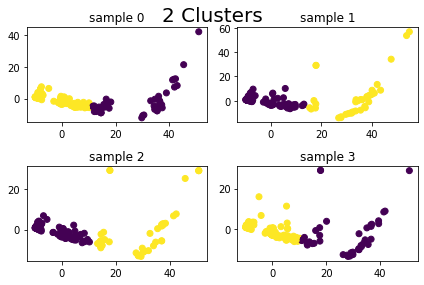

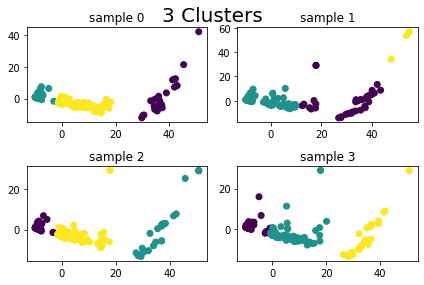

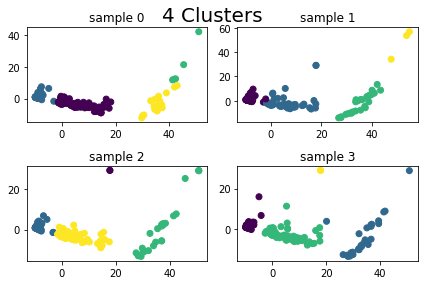

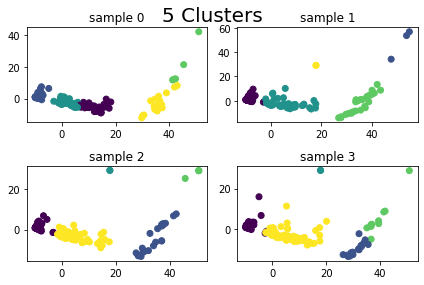

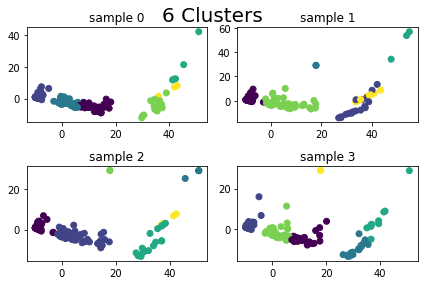

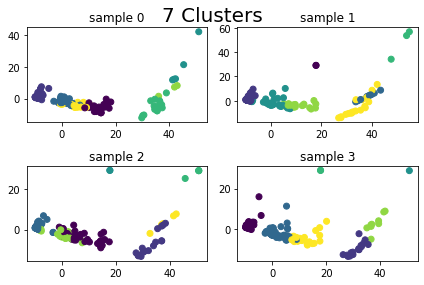

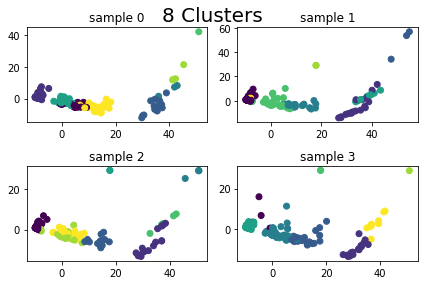

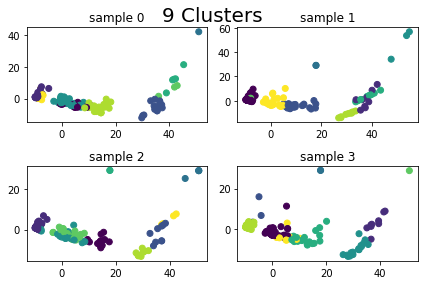

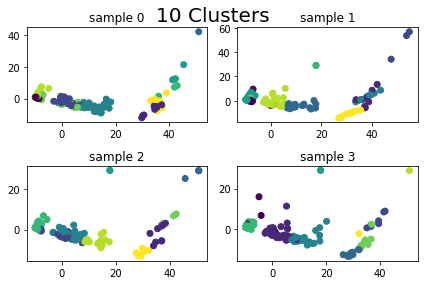

In [0]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 11):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(2, 2)
    
    # Make a plot for each sample.
    for i in range(4):
        
        # PCA-created features.
        x_sub = y_pred['pca_f1_sample{}'.format(i)]
        y_sub = y_pred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = y_pred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
#         axarr[rows, cols].set_xlim([-.3, .3])
#         axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

Using 4-clusters, the data points in each cluster shows similarities.

In [0]:
# use 4 clusters
nclust=4
kmean=KMeans(n_clusters=nclust, random_state=42).fit(X_res2)
y_pred = kmean.predict(X_res2)
y_pred = pd.DataFrame(y_pred, columns=['pred'])

In [0]:
# reconstruct the results X-pca with Y_true, Y_pred
X_pca = pd.DataFrame(data = X_pca, columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([X_pca, Y_res2, y_pred], axis = 1)

We are using the 'Class' (target) feature to help determine how the clustering works. Below shows the 4 clusters labeled in colors (0 = no fraud, 1= fraud).

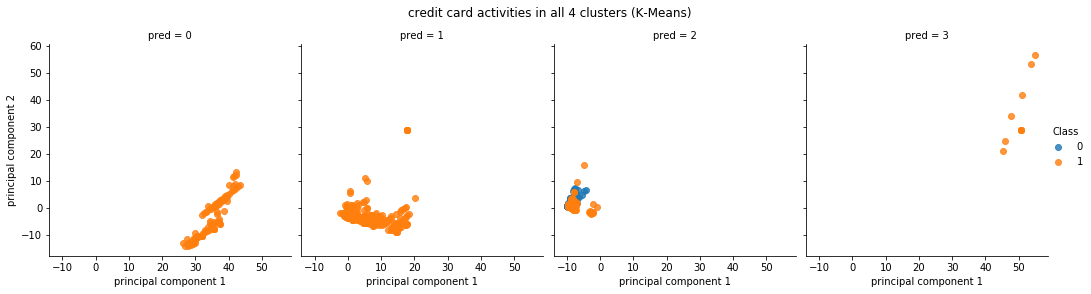

In [0]:
g =sns.lmplot(data=finalDf, x='principal component 1', y='principal component 2', hue='Class', col='pred', 
           fit_reg=False, legend=True, legend_out=True)
g.fig.set_size_inches(15,4)
plt.subplots_adjust(top=0.85)
g.fig.suptitle('credit card activities in all 4 clusters (K-Means)')

plt.show()

Interestingly all the non-fraud shows up in pred=2 cluster. Based on the observation of the two plots above, we are going to regroup the cluster 0,1, and 3 into the positive group(class=1). Cluster 2 is the negative group (class =0).

In [0]:
# create the column name 'pred2', the predictive result from the K-mean after regroup. 
# finalDf is the predictive result from **training** dataset
finalDf.loc[(finalDf['pred']==3), 'pred2']=1
finalDf.loc[(finalDf['pred']==2), 'pred2']=0
finalDf.loc[(finalDf['pred']==1), 'pred2']=1
finalDf.loc[(finalDf['pred']==0), 'pred2']=1
finalDf['pred2']=finalDf['pred2'].astype(int)

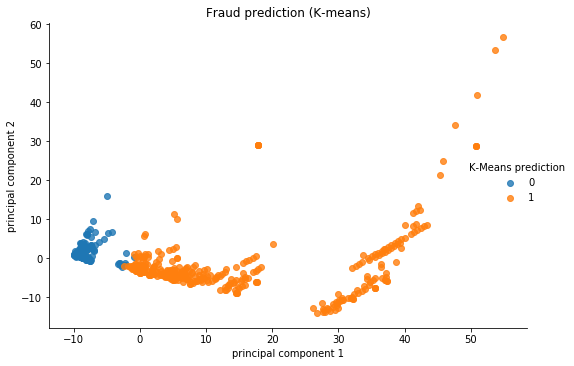

In [0]:
# Plotting after regrouping

g= sns.lmplot(data=finalDf, x='principal component 1', y='principal component 2', hue='pred2', 
           fit_reg=False, legend=True, legend_out=True, height=5, aspect=1.6)
g.fig.set_size_inches(8,5)
g._legend.set_title('K-Means prediction')
plt.title('Fraud prediction (K-means)')
plt.show()

In [0]:
# confusion matrix

from sklearn.metrics import confusion_matrix
print (("f1 score for K-Means : {} ").format(round(f1_score(finalDf['Class'], finalDf['pred2']), 3 ) ))
cm = confusion_matrix(finalDf['Class'], finalDf['pred2'])
cm = pd.DataFrame(cm, columns=['No Fraud (Predicted)', 'Fraud (Predicted)'], index = ['No Fraud (Actual)', 'Fraud (Actual)'])
print(cm)

f1 score for K-Means : 0.877 
                   No Fraud (Predicted)  Fraud (Predicted)
No Fraud (Actual)                   492                  0
Fraud (Actual)                      108                384


In [0]:
# classification report: the focus is f1-score and recall
from sklearn.metrics import classification_report
print(classification_report(finalDf['Class'], finalDf['pred2'], digits=4))

              precision    recall  f1-score   support

           0     0.8200    1.0000    0.9011       492
           1     1.0000    0.7805    0.8767       492

    accuracy                         0.8902       984
   macro avg     0.9100    0.8902    0.8889       984
weighted avg     0.9100    0.8902    0.8889       984



With K-mean clustering, 384 out of 492 fraudulent cases are called.  The recall index is 0.78 and the f1-score is 0.88.  

# Mean Shift clustering

In [0]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_res2, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_res2)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 4


The mean shift clustering also suggests 4 clusters.

In [0]:

# The results from Mean shift clustering is called 'pred3'
y_pred=pd.DataFrame(labels, columns=['pred3'])
finalDf = pd.concat([finalDf, y_pred], axis = 1)

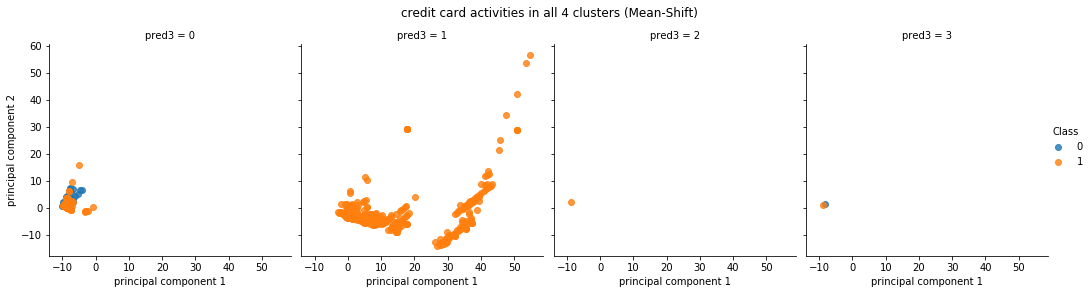

In [0]:
# Plotting Mean Shift clustering
g = sns.lmplot(data=finalDf, x='principal component 1', y='principal component 2', hue='Class', col='pred3', 
           fit_reg=False, legend=True, legend_out=True)
g.fig.set_size_inches(15,4)
plt.subplots_adjust(top=0.85)
g.fig.suptitle('credit card activities in all 4 clusters (Mean-Shift)')


plt.show()

Based on the observation, we can regroup the pred3 = 1, 2, 3 in to a new positive group. Pred3=0 is the negative group

In [0]:
# create 'pred4' for the Mean shift regroup predictive results
finalDf.loc[(finalDf['pred3']==3), 'pred4']=1
finalDf.loc[(finalDf['pred3']==2), 'pred4']=1
finalDf.loc[(finalDf['pred3']==1), 'pred4']=1
finalDf.loc[(finalDf['pred3']==0), 'pred4']=0
finalDf['pred4']=finalDf['pred4'].astype(int)

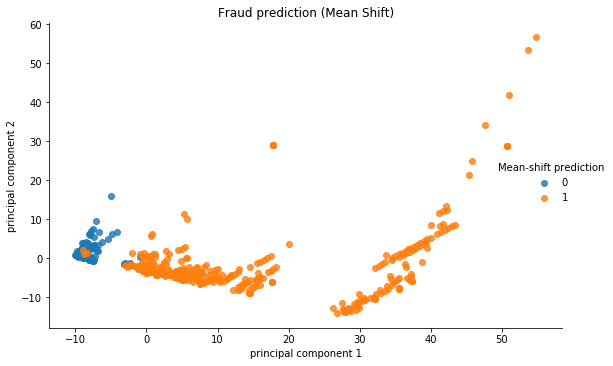

In [0]:
g= sns.lmplot(data=finalDf, x='principal component 1', y='principal component 2', hue='pred4', 
           fit_reg=False, legend=True, legend_out=True, height=5, aspect=1.6)
g._legend.set_title('Mean-shift prediction')
plt.title('Fraud prediction (Mean Shift)')
plt.show()

In [0]:
# confusion matrix 


print (("f1 score for Mean-Shift : {} ").format(round(f1_score(finalDf['Class'], finalDf['pred4']), 3 ) ))
cm = confusion_matrix(finalDf['Class'], finalDf['pred4'])
cm = pd.DataFrame(cm, columns=['No Fraud (Predicted)', 'Fraud (Predicted)'], index = ['No Fraud (Actual)', 'Fraud (Actual)'])
print(cm)

f1 score for Mean-Shift : 0.885 
                   No Fraud (Predicted)  Fraud (Predicted)
No Fraud (Actual)                   491                  1
Fraud (Actual)                      101                391


In [0]:

# Classification Report: focus on recall and f1-score
print(classification_report(finalDf['Class'], finalDf['pred4'], digits=4))

              precision    recall  f1-score   support

           0     0.8294    0.9980    0.9059       492
           1     0.9974    0.7947    0.8846       492

    accuracy                         0.8963       984
   macro avg     0.9134    0.8963    0.8953       984
weighted avg     0.9134    0.8963    0.8953       984



In the test database, 391 out of 492 fraud cases are called.  The recall index is 0.79, and the f1-score is 0.88.  

## Elbow methods for evaluating number of clusters in K-Means

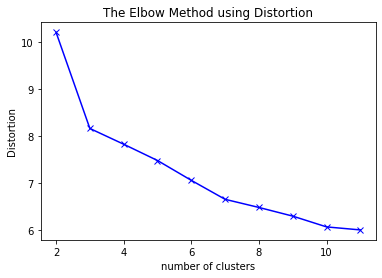

In [0]:
# elbow method
from scipy.spatial.distance import cdist
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(2, 12)
for k in K:
    #Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X_res2)
    kmeanModel.fit(X_res2)    

    # distortion method
    distortions.append(sum(np.min(cdist(X_res2, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X_res2.shape[0])
    mapping1[k] = sum(np.min(cdist(X_res2, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X_res2.shape[0]
#     # inertia method
#     inertias.append(kmeanModel.inertia_)
#     mapping2[k] = kmeanModel.inertia_

# Distortion method:          
#It is calculated as the average of the squared distances from the cluster centers of the respective clusters. Typically, the #Euclidean distance metric is used

#for key,val in mapping1.items():
#    print(str(key)+' : '+str(val))

plt.plot(K, distortions, 'bx-')
plt.xlabel('number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

The more cluster, the small distortion. The distortion is flatten out after k=10. We see the first elbow at k=3. In deed, even at k=3, we were able to regroup the clusters and find a good predicting results. 

# Model implementation

We pick f1-score as the performance metric.  Random forest classifier is the chosen model for the highest f1-score.  The analysis can be repeated monthly with renewal data to validate the model, or invalidate the current model and pick a new model if necessary. 

Once the model is built and the parameters are set.  The new transaction data can be fed to the model.  It means in the fraudulent activities can be detected in real time.  If the transaction is classified as potential fraudulent, the transaction may be declined, and further action can be implemented.  For example, a text message can be sent to the credit card holder to ask for transaction verification.  The text message system can help resolve the false positive cases.  

# Conclusions

The project includes an extensive study on supervised machine learning models, and clustering skills on unsupervised models.  Fraudulent activities can be detected using these models.  Procedures can be taken to prevent further financial loss by the fraud activities.  

It is noteworthy that accuracy is not a suitable performance metric in this study.  If catching as much as frauds is of the best interest, recall index is the model performance metric we should look for.  In this case, logistic regression model is the most suitable.  The downside of choosing recall is that the model would make quite a few false positive cases.  

We mostly focuses on f1-scores in this study because it is a balance between precision and recall.  Therefore, random forest, adaboosting, stacking, lightgbm are the recommended models for their f1-score greater than 0.8 on testing dataset.  
